##***DeepFake Detection Using Deep Learning***




## **Setup and Library Imports**

In [8]:
import os
import torch
from torch import nn
import random
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

In [2]:
seed=40302
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
import os
os.chdir('../')

In [4]:
os.getcwd()

'h:\\project'

## **Helper Functions**

In [5]:
from src.utils import *

## **Data Reading, Splitting and Loading**

In [6]:
from src.dataset import *

In [7]:
train_df, valid_df, _, _ = load_data()

In [8]:
_, pso_index = get_split(train_df, size=0.05)
train_pso = train_df.loc[pso_index, :]
train_pso.reset_index(drop=True, inplace=True)
train_pso.label.value_counts()

FAKE    187
REAL    185
Name: label, dtype: int64

In [9]:
_, pso_index = get_split(valid_df, size=0.25)
valid_pso = valid_df.loc[pso_index, :]
valid_pso.reset_index(drop=True, inplace=True)
valid_pso.label.value_counts()

FAKE    216
REAL    120
Name: label, dtype: int64

In [10]:
train_pso.head()

,filename,label,path,origin,frames,inv_frame
0,xjzmkuxskq.mp4,REAL,h:\project\dfdc\dfdc_part_1_1\xjzmkuxskq,dfdc,1,0
1,id42_id48_0002.mp4,FAKE,h:\project\CelebDF-v2\faces\id42_id48_0002,CelebDF-v2,1,0
2,jkonwkrhqp.mp4,REAL,h:\project\dfdc\dfdc_part_2_2\jkonwkrhqp,dfdc,3,1
3,Sally_Kirkland_2,REAL,./youtube_faces_dataset/faces\Sally_Kirkland_2,ytf,1,0
4,vejylrlysf.mp4,FAKE,h:\project\dfdc\dfdc_part_2_1\vejylrlysf,dfdc,1,0


## **Run PSO optimization loop**

In [11]:
from src.models.deepfake_detectors import Efficientnet
from src.train_val_funcs import train_epoch, run_inference
from pso import *

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


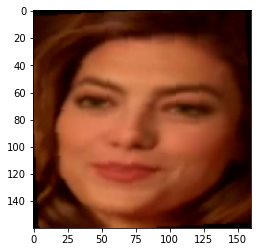

In [12]:
#preprocess the data
train_data = VideoDataset(train_pso, 50, transform = train_transforms(160))
val_data = VideoDataset(valid_pso, 50, transform = test_transforms(160))

#load the data into dataloaders
train_loader = DataLoader(train_data, batch_size = 4, shuffle = True, num_workers = 0)
valid_loader = DataLoader(val_data, batch_size = 4, shuffle = True, num_workers = 0)
#plot the data
image,label = train_data[1]
im_plot(image[1,:,:,:])

In [13]:

def train_function(learning_rate=0.001, dropout_rate=0.3, image_size=112, frames_to_use=50, weight_decay=1e-5):
    #learning rate
    lr = learning_rate
    
    #preprocess the data
    train_data = VideoDataset(train_pso, frames_to_use, image_size, transform = train_transforms(image_size) )
    val_data = VideoDataset(valid_pso, frames_to_use, image_size, transform = test_transforms(image_size) )

    #load the data into dataloaders
    train_loader = DataLoader(train_data, batch_size = 4, shuffle = True, num_workers = 0)
    valid_loader = DataLoader(val_data, batch_size = 4, shuffle = True, num_workers = 0)
    
    #instantiate the model
    model1 = Efficientnet(2, dropout_rate).cuda()
    #number of epochs 
    num_epochs = 5

    optimizer = torch.optim.Adam(model1.parameters(), lr= lr, weight_decay = weight_decay)

    criterion = nn.CrossEntropyLoss().cuda()
    train_loss_avg =[]
    train_accuracy = []
    val_loss_avg = []
    val_accuracy = []
    best_accuracy = 0
    for epoch in range(1,num_epochs+1):
        l, acc = train_epoch(epoch,train_loader,model1,criterion,optimizer)
        train_loss_avg.append(l)
        train_accuracy.append(acc)
        #validation step
        true,pred,tl,t_acc = run_inference(model1,valid_loader,criterion)
        val_loss_avg.append(tl)
        val_accuracy.append(t_acc)
        if t_acc > best_accuracy:
            best_accuracy = t_acc
            torch.save(model1.state_dict(),'./effnet_{}.pt'.format(epoch))
    return tl
    

In [14]:
pso = PSO(w=0.5, hyperparam={'learning_rate':[1e-5, 1e-3], 'dropout_rate': [0.1, 0.9], 'image_size': [100, 128], 
                             'frames_to_use': [10,50] }, c1=1.2, c2=1.2, num_particles=10)

In [15]:
pso.run(train_function, generations=20)

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([7.05736117e-04, 1.47053148e-01, 1.06000000e+02, 3.50000000e+01]), array([3.86384573e-04, 2.86634639e-01, 1.03000000e+02, 3.70000000e+01]), array([2.17358482e-04, 4.35151260e-01, 1.01000000e+02, 4.10000000e+01]), array([2.17358482e-04, 4.35151260e-01, 1.01000000e+02, 4.10000000e+01]), array([2.17358482e-04, 4.35151260e-01, 1.01000000e+02, 4.10000000e+01]), array([2.70597153e-04, 2.32790810e-01, 1.01000000e+02, 3.80000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.44483289e-04, 2.89744756e-01, 1.00000000e+02, 4.00000000e+01]), array([2.44483289e-04, 2.89744756e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([2.44908245e-04, 6.01489829e-01, 1.16000000e+02, 3.20000000e+01]), array([2.36643464e-04, 2.12173567e-01, 1.00000000e+02, 3.30000000e+01]), array([2.36643464e-04, 2.12173567e-01, 1.00000000e+02, 3.30000000e+01]), array([2.36293883e-04, 2.09092478e-01, 1.00000000e+02, 3.30000000e+01]), array([2.36293883e-04, 2.09092478e-01, 1.00000000e+02, 3.30000000e+01]), array([2.36293883e-04, 2.09092478e-01, 1.00000000e+02, 3.30000000e+01]), array([2.36293883e-04, 2.09092478e-01, 1.00000000e+02, 3.30000000e+01]), array([2.33175877e-04, 1.97397447e-01, 1.01000000e+02, 3.80000000e+01]), array([2.33175877e-04, 1.97397447e-01, 1.01000000e+02, 3.80000000e+01]), array([2.81218958e-04, 1.97901006e-01, 1.04000000e+02, 3.60000000e+01]), array([2.81218958e-04, 1.97901006e-01, 1.04000000e+02, 3.60000000e+01]), array([2.81218958e-04, 1.97901006e-01, 1.04000000e+02, 3.60000000e+01]), array([2.81218958e-04, 1.97901006e-01, 1.04000000e+02, 3.60000000e+01]), array([2.81218958e-04, 1.97901006e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([7.63695015e-05, 5.11396445e-01, 1.09000000e+02, 1.70000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.73185298e-04, 3.68418563e-01, 1.04000000e+02, 3.30000000e+01]), array([2.73185298e-04, 3.68418563e-01, 1.04000000e+02, 3.30000000e+01]), array([2.73185298e-04, 3.68418563e-01, 1.04000000e+02, 3.30000000e+01]), array([2.73185298e-04, 3.68418563e-01, 1.04000000e+02, 3.30000000e+01]), array([2.73185298e-04, 3.68418563e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([6.96088433e-04, 3.69036300e-01, 1.21000000e+02, 4.80000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([4.20306856e-04, 3.51159359e-01, 1.09000000e+02, 4.10000000e+01]), array([5.50721832e-04, 3.57552005e-01, 1.09000000e+02, 3.40000000e+01]), array([5.50721832e-04, 3.57552005e-01, 1.09000000e+02, 3.40000000e+01]), array([5.50721832e-04, 3.57552005e-01, 1.09000000e+02, 3.40000000e+01]), array([2.36017888e-04, 1.98008123e-01, 1.01000000e+02, 3.20000000e+01]), array([1.48381613e-04, 1.69611473e-01, 1.00000000e+02, 3.30000000e+01]), array([1.11878604e-04, 1.62576061e-01, 1.00000000e+02, 3.50000000e+01]), array([1.11878604e-04, 1.62576061e-01, 1.00000000e+02, 3.50000000e+01]), array([1.11878604e-04, 1.62576061e-01, 1.00000000e+02, 3.50000000e+01]), array([1.11878604e-04, 1.62576061e-01, 1.00000000e+02, 3.50000000e+01]), array([1.11878604e-04, 1.62576061e-01, 1.00000000e+02, 3.50000000e+01]), array([1.11878604e-04, 1.62576061e-01, 1.00000000e+02, 3.50000000e+01]), array([1.11878604e-04, 1.62576061e-01, 1.00000000e+02, 3.50000000e+01]), array([1.11878604e-04, 1.62576061e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([2.75496862e-04, 4.50449172e-01, 1.10000000e+02, 2.80000000e+01]), array([2.83657417e-04, 5.64738237e-01, 1.08000000e+02, 1.70000000e+01]), array([2.83657417e-04, 5.64738237e-01, 1.08000000e+02, 1.70000000e+01]), array([2.83657417e-04, 5.64738237e-01, 1.08000000e+02, 1.70000000e+01]), array([2.83657417e-04, 5.64738237e-01, 1.08000000e+02, 1.70000000e+01]), array([2.46755243e-04, 4.25774957e-01, 1.06000000e+02, 1.90000000e+01]), array([2.09809717e-04, 4.19396114e-01, 1.02000000e+02, 2.90000000e+01]), array([1.93689095e-04, 2.85859081e-01, 1.00000000e+02, 4.50000000e+01]), array([1.98481105e-04, 2.08616215e-01, 1.01000000e+02, 4.80000000e+01]), array([1.98481105e-04, 2.08616215e-01, 1.01000000e+02, 4.80000000e+01]), array([1.98481105e-04, 2.08616215e-01, 1.01000000e+02, 4.80000000e+01]), array([1.98481105e-04, 2.08616215e-01, 1.01000000e+02, 4.80000000e+01]), array([2.36682679e-04, 3.77994658e-01, 1.01000000e+02, 3.40000000e+01]), array([2.36682679e-04, 3.77994658e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([1.29044722e-04, 7.78489807e-01, 1.07000000e+02, 2.50000000e+01]), array([1.29044722e-04, 7.78489807e-01, 1.07000000e+02, 2.50000000e+01]), array([6.18717922e-05, 6.78094135e-01, 1.12000000e+02, 3.60000000e+01]), array([6.18717922e-05, 6.78094135e-01, 1.12000000e+02, 3.60000000e+01]), array([6.18717922e-05, 6.78094135e-01, 1.12000000e+02, 3.60000000e+01]), array([6.50400707e-05, 4.62069056e-01, 1.05000000e+02, 3.40000000e+01]), array([1.13920598e-04, 3.39113923e-01, 1.01000000e+02, 3.80000000e+01]), array([1.84343060e-04, 1.58540292e-01, 1.00000000e+02, 4.10000000e+01]), array([2.33857670e-04, 1.44673118e-01, 1.00000000e+02, 4.20000000e+01]), array([2.90705237e-04, 1.75078674e-01, 1.05000000e+02, 3.70000000e+01]), array([3.24801432e-04, 1.97589046e-01, 1.08000000e+02, 3.40000000e+01]), array([3.24801432e-04, 1.97589046e-01, 1.08000000e+02, 3.40000000e+01]), array([3.24801432e-04, 1.97589046e-01, 1.08000000e+02, 3.40000000e+01]), array([3.24801432e-04, 1.97589046e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([3.40137516e-04, 4.63241630e-01, 1.02000000e+02, 4.20000000e+01]), array([3.40137516e-04, 4.63241630e-01, 1.02000000e+02, 4.20000000e+01]), array([3.40137516e-04, 4.63241630e-01, 1.02000000e+02, 4.20000000e+01]), array([3.40137516e-04, 4.63241630e-01, 1.02000000e+02, 4.20000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([7.49841801e-04, 6.74450274e-01, 1.00000000e+02, 2.00000000e+01]), array([7.08454869e-04, 4.35989451e-01, 1.05000000e+02, 2.30000000e+01]), array([2.75370458e-04, 3.19271604e-01, 1.06000000e+02, 4.00000000e+01]), array([2.75370458e-04, 3.19271604e-01, 1.06000000e+02, 4.00000000e+01]), array([2.75370458e-04, 3.19271604e-01, 1.06000000e+02, 4.00000000e+01]), array([2.75370458e-04, 3.19271604e-01, 1.06000000e+02, 4.00000000e+01]), array([3.07126403e-04, 2.83968040e-01, 1.04000000e+02, 4.20000000e+01]), array([3.07126403e-04, 2.83968040e-01, 1.04000000e+02, 4.20000000e+01]), array([3.07126403e-04, 2.83968040e-01, 1.04000000e+02, 4.20000000e+01]), array([3.07126403e-04, 2.83968040e-01, 1.04000000e+02, 4.20000000e+01]), array([3.07126403e-04, 2.83968040e-01, 1.04000000e+02, 4.20000000e+01]), array([2.48213593e-04, 2.97007662e-01, 1.05000000e+02, 4.00000000e+01]), array([2.32671752e-04, 3.49445648e-01, 1.03000000e+02, 3.40000000e+01]), array([2.32671752e-04, 3.49445648e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([5.87129720e-04, 8.55067083e-01, 1.06000000e+02, 1.00000000e+01]), array([3.82507046e-04, 7.80062843e-01, 1.00000000e+02, 3.40000000e+01]), array([3.82507046e-04, 7.80062843e-01, 1.00000000e+02, 3.40000000e+01]), array([3.82507046e-04, 7.80062843e-01, 1.00000000e+02, 3.40000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([7.05736117e-04, 1.47053148e-01, 1.06000000e+02, 3.50000000e+01]), array([3.86384573e-04, 2.86634639e-01, 1.03000000e+02, 3.70000000e+01]), array([2.17358482e-04, 4.35151260e-01, 1.01000000e+02, 4.10000000e+01]), array([2.17358482e-04, 4.35151260e-01, 1.01000000e+02, 4.10000000e+01]), array([2.17358482e-04, 4.35151260e-01, 1.01000000e+02, 4.10000000e+01]), array([2.70597153e-04, 2.32790810e-01, 1.01000000e+02, 3.80000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.44483289e-04, 2.89744756e-01, 1.00000000e+02, 4.00000000e+01]), array([2.44483289e-04, 2.89744756e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([2.44908245e-04, 6.01489829e-01, 1.16000000e+02, 3.20000000e+01]), array([2.36643464e-04, 2.12173567e-01, 1.00000000e+02, 3.30000000e+01]), array([2.36643464e-04, 2.12173567e-01, 1.00000000e+02, 3.30000000e+01]), array([2.36293883e-04, 2.09092478e-01, 1.00000000e+02, 3.30000000e+01]), array([2.36293883e-04, 2.09092478e-01, 1.00000000e+02, 3.30000000e+01]), array([2.36293883e-04, 2.09092478e-01, 1.00000000e+02, 3.30000000e+01]), array([2.36293883e-04, 2.09092478e-01, 1.00000000e+02, 3.30000000e+01]), array([2.33175877e-04, 1.97397447e-01, 1.01000000e+02, 3.80000000e+01]), array([2.33175877e-04, 1.97397447e-01, 1.01000000e+02, 3.80000000e+01]), array([2.81218958e-04, 1.97901006e-01, 1.04000000e+02, 3.60000000e+01]), array([2.81218958e-04, 1.97901006e-01, 1.04000000e+02, 3.60000000e+01]), array([2.81218958e-04, 1.97901006e-01, 1.04000000e+02, 3.60000000e+01]), array([2.81218958e-04, 1.97901006e-01, 1.04000000e+02, 3.60000000e+01]), array([2.81218958e-04, 1.97901006e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([7.63695015e-05, 5.11396445e-01, 1.09000000e+02, 1.70000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.73185298e-04, 3.68418563e-01, 1.04000000e+02, 3.30000000e+01]), array([2.73185298e-04, 3.68418563e-01, 1.04000000e+02, 3.30000000e+01]), array([2.73185298e-04, 3.68418563e-01, 1.04000000e+02, 3.30000000e+01]), array([2.73185298e-04, 3.68418563e-01, 1.04000000e+02, 3.30000000e+01]), array([2.73185298e-04, 3.68418563e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([6.96088433e-04, 3.69036300e-01, 1.21000000e+02, 4.80000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([4.20306856e-04, 3.51159359e-01, 1.09000000e+02, 4.10000000e+01]), array([5.50721832e-04, 3.57552005e-01, 1.09000000e+02, 3.40000000e+01]), array([5.50721832e-04, 3.57552005e-01, 1.09000000e+02, 3.40000000e+01]), array([5.50721832e-04, 3.57552005e-01, 1.09000000e+02, 3.40000000e+01]), array([2.36017888e-04, 1.98008123e-01, 1.01000000e+02, 3.20000000e+01]), array([1.48381613e-04, 1.69611473e-01, 1.00000000e+02, 3.30000000e+01]), array([1.11878604e-04, 1.62576061e-01, 1.00000000e+02, 3.50000000e+01]), array([1.11878604e-04, 1.62576061e-01, 1.00000000e+02, 3.50000000e+01]), array([1.11878604e-04, 1.62576061e-01, 1.00000000e+02, 3.50000000e+01]), array([1.11878604e-04, 1.62576061e-01, 1.00000000e+02, 3.50000000e+01]), array([1.11878604e-04, 1.62576061e-01, 1.00000000e+02, 3.50000000e+01]), array([1.11878604e-04, 1.62576061e-01, 1.00000000e+02, 3.50000000e+01]), array([1.11878604e-04, 1.62576061e-01, 1.00000000e+02, 3.50000000e+01]), array([1.11878604e-04, 1.62576061e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([2.75496862e-04, 4.50449172e-01, 1.10000000e+02, 2.80000000e+01]), array([2.83657417e-04, 5.64738237e-01, 1.08000000e+02, 1.70000000e+01]), array([2.83657417e-04, 5.64738237e-01, 1.08000000e+02, 1.70000000e+01]), array([2.83657417e-04, 5.64738237e-01, 1.08000000e+02, 1.70000000e+01]), array([2.83657417e-04, 5.64738237e-01, 1.08000000e+02, 1.70000000e+01]), array([2.46755243e-04, 4.25774957e-01, 1.06000000e+02, 1.90000000e+01]), array([2.09809717e-04, 4.19396114e-01, 1.02000000e+02, 2.90000000e+01]), array([1.93689095e-04, 2.85859081e-01, 1.00000000e+02, 4.50000000e+01]), array([1.98481105e-04, 2.08616215e-01, 1.01000000e+02, 4.80000000e+01]), array([1.98481105e-04, 2.08616215e-01, 1.01000000e+02, 4.80000000e+01]), array([1.98481105e-04, 2.08616215e-01, 1.01000000e+02, 4.80000000e+01]), array([1.98481105e-04, 2.08616215e-01, 1.01000000e+02, 4.80000000e+01]), array([2.36682679e-04, 3.77994658e-01, 1.01000000e+02, 3.40000000e+01]), array([2.36682679e-04, 3.77994658e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([1.29044722e-04, 7.78489807e-01, 1.07000000e+02, 2.50000000e+01]), array([1.29044722e-04, 7.78489807e-01, 1.07000000e+02, 2.50000000e+01]), array([6.18717922e-05, 6.78094135e-01, 1.12000000e+02, 3.60000000e+01]), array([6.18717922e-05, 6.78094135e-01, 1.12000000e+02, 3.60000000e+01]), array([6.18717922e-05, 6.78094135e-01, 1.12000000e+02, 3.60000000e+01]), array([6.50400707e-05, 4.62069056e-01, 1.05000000e+02, 3.40000000e+01]), array([1.13920598e-04, 3.39113923e-01, 1.01000000e+02, 3.80000000e+01]), array([1.84343060e-04, 1.58540292e-01, 1.00000000e+02, 4.10000000e+01]), array([2.33857670e-04, 1.44673118e-01, 1.00000000e+02, 4.20000000e+01]), array([2.90705237e-04, 1.75078674e-01, 1.05000000e+02, 3.70000000e+01]), array([3.24801432e-04, 1.97589046e-01, 1.08000000e+02, 3.40000000e+01]), array([3.24801432e-04, 1.97589046e-01, 1.08000000e+02, 3.40000000e+01]), array([3.24801432e-04, 1.97589046e-01, 1.08000000e+02, 3.40000000e+01]), array([3.24801432e-04, 1.97589046e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([3.40137516e-04, 4.63241630e-01, 1.02000000e+02, 4.20000000e+01]), array([3.40137516e-04, 4.63241630e-01, 1.02000000e+02, 4.20000000e+01]), array([3.40137516e-04, 4.63241630e-01, 1.02000000e+02, 4.20000000e+01]), array([3.40137516e-04, 4.63241630e-01, 1.02000000e+02, 4.20000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]), array([2.15016098e-04, 2.25545053e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([7.49841801e-04, 6.74450274e-01, 1.00000000e+02, 2.00000000e+01]), array([7.08454869e-04, 4.35989451e-01, 1.05000000e+02, 2.30000000e+01]), array([2.75370458e-04, 3.19271604e-01, 1.06000000e+02, 4.00000000e+01]), array([2.75370458e-04, 3.19271604e-01, 1.06000000e+02, 4.00000000e+01]), array([2.75370458e-04, 3.19271604e-01, 1.06000000e+02, 4.00000000e+01]), array([2.75370458e-04, 3.19271604e-01, 1.06000000e+02, 4.00000000e+01]), array([3.07126403e-04, 2.83968040e-01, 1.04000000e+02, 4.20000000e+01]), array([3.07126403e-04, 2.83968040e-01, 1.04000000e+02, 4.20000000e+01]), array([3.07126403e-04, 2.83968040e-01, 1.04000000e+02, 4.20000000e+01]), array([3.07126403e-04, 2.83968040e-01, 1.04000000e+02, 4.20000000e+01]), array([3.07126403e-04, 2.83968040e-01, 1.04000000e+02, 4.20000000e+01]), array([2.48213593e-04, 2.97007662e-01, 1.05000000e+02, 4.00000000e+01]), array([2.32671752e-04, 3.49445648e-01, 1.03000000e+02, 3.40000000e+01]), array([2.32671752e-04, 3.49445648e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([5.87129720e-04, 8.55067083e-01, 1.06000000e+02, 1.00000000e+01]), array([3.82507046e-04, 7.80062843e-01, 1.00000000e+02, 3.40000000e+01]), array([3.82507046e-04, 7.80062843e-01, 1.00000000e+02, 3.40000000e+01]), array([3.82507046e-04, 7.80062843e-01, 1.00000000e+02, 3.40000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-01, 1.00000000e+02, 1.00000000e+01]), array([2.08328216e-04, 2.39779914e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([7.05736117e-04, 1.47053148e-01, 1.06000000e+02, 3.50000000e+01]), array([3.86384573e-04, 2.86634639e-01, 1.03000000e+02, 3.70000000e+01]), array([2.17358482e-04, 4.35151260e-01, 1.01000000e+02, 4.10000000e+01]), array([2.17358482e-04, 4.35151260e-01, 1.01000000e+02, 4.10000000e+01]), array([2.17358482e-04, 4.35151260e-01, 1.01000000e+02, 4.10000000e+01]), array([2.70597153e-04, 2.32790810e-01, 1.01000000e+02, 3.80000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.51706785e-04, 2.16479510e-01, 1.01000000e+02, 4.20000000e+01]), array([2.44483289e-04, 2.89744756e-01, 1.00000000e+02, 4.00000000e+01]), array([2.44483289e-04, 2.89744756e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([2.44908245e-04, 6.01489829e-01, 1.16000000e+02, 3.20000000e+01]), array([2.36643464e-04, 2.12173567e-01, 1.00000000e+02, 3.30000000e+01]), array([2.36643464e-04, 2.12173567e-01, 1.00000000e+02, 3.30000000e+01]), array([2.36293883e-04, 2.09092478e-01, 1.00000000e+02, 3.30000000e+01]), array([2.36293883e-04, 2.09092478e-01, 1.00000000e+02, 3.30000000e+01]), array([2.36293883e-04, 2.09092478e-01, 1.00000000e+02, 3.30000000e+01]), array([2.36293883e-04, 2.09092478e-01, 1.00000000e+02, 3.30000000e+01]), array([2.33175877e-04, 1.97397447e-01, 1.01000000e+02, 3.80000000e+01]), array([2.33175877e-04, 1.97397447e-01, 1.01000000e+02, 3.80000000e+01]), array([2.81218958e-04, 1.97901006e-01, 1.04000000e+02, 3.60000000e+01]), array([2.81218958e-04, 1.97901006e-01, 1.04000000e+02, 3.60000000e+01]), array([2.81218958e-04, 1.97901006e-01, 1.04000000e+02, 3.60000000e+01]), array([2.81218958e-04, 1.97901006e-01, 1.04000000e+02, 3.60000000e+01]), array([2.81218958e-04, 1.97901006e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([7.63695015e-05, 5.11396445e-01, 1.09000000e+02, 1.70000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.99218928e-04, 6.14941474e-01, 1.03000000e+02, 2.80000000e+01]), array([2.73185298e-04, 3.68418563e-01, 1.04000000e+02, 3.30000000e+01]), array([2.73185298e-04, 3.68418563e-01, 1.04000000e+02, 3.30000000e+01]), array([2.73185298e-04, 3.68418563e-01, 1.04000000e+02, 3.30000000e+01]), array([2.73185298e-04, 3.68418563e-01, 1.04000000e+02, 3.30000000e+01]), array([2.73185298e-04, 3.68418563e-

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

personal best  [array([6.96088433e-04, 3.69036300e-01, 1.21000000e+02, 4.80000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([6.93445998e-04, 5.52352815e-01, 1.08000000e+02, 3.50000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]), array([3.20876308e-04, 1.97684185e-

In [16]:
pso.gbest

[array([3.40137516e-04, 4.63241630e-01, 1.02000000e+02, 4.20000000e+01]),
 array([2.36643464e-04, 2.12173567e-01, 1.00000000e+02, 3.30000000e+01]),
 array([2.36643464e-04, 2.12173567e-01, 1.00000000e+02, 3.30000000e+01]),
 array([2.36293883e-04, 2.09092478e-01, 1.00000000e+02, 3.30000000e+01]),
 array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]),
 array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]),
 array([2.15016098e-04, 2.25545053e-01, 1.02000000e+02, 3.90000000e+01]),
 array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]),
 array([3.20876308e-04, 1.97684185e-01, 1.07000000e+02, 3.70000000e+01]),
 array([2.73185298e-04, 3.68418563e-01, 1.04000000e+02, 3.30000000e+01]),
 array([2.73185298e-04, 3.68418563e-01, 1.04000000e+02, 3.30000000e+01]),
 array([2.73185298e-04, 3.68418563e-01, 1.04000000e+02, 3.30000000e+01]),
 array([2.73185298e-04, 3.68418563e-01, 1.04000000e+02, 3.30000000e+01]),
 array([2.73185298e-04, 3.68418563e-01

In [55]:
gbest = pd.DataFrame(pso.gbest, columns=['lr', 'dropout', 'im_size', 'num_frames'])
pbest = [pd.DataFrame(p.pbest, columns=['lr', 'dropout', 'im_size', 'num_frames']) for p in pso.particles]
pos = [pd.DataFrame(p.pos, columns=['lr', 'dropout', 'im_size', 'num_frames']) for p in pso.particles]
p = [pd.concat([pbest[i], pos[i]], axis=1) for i in range(len(pbest))]



In [58]:
pos = [p.rename for p in pos]

,lr,dropout,im_size,num_frames,lr,dropout,im_size,num_frames
0,0.000420,0.351159,109.0,41.0,0.000420,0.351159,109.0,41.0
1,0.000551,0.357552,109.0,34.0,0.000551,0.357552,109.0,34.0
2,0.000551,0.357552,109.0,34.0,0.000490,0.432131,104.0,32.0
3,0.000551,0.357552,109.0,34.0,0.000411,0.280301,104.0,31.0
4,0.000236,0.198008,101.0,32.0,0.000236,0.198008,101.0,32.0


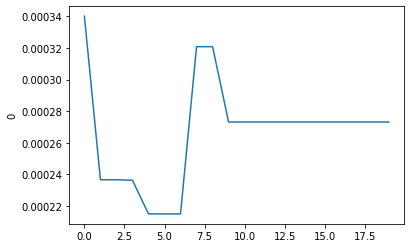

In [40]:
import seaborn as sns
plt.figure()
sns.lineplot(data=gbest.loc[:,0])
for i,p in enumerate(pbest):
    p.position = pos[i].loc[:,0]
#    sns.lineplot(data=p.loc[:,0], hue='position' )

In [46]:
pbest[0].pos = pos[0].loc[:,0].to_list()

In [45]:
pos[0].loc[:,0].to_list()

[0.0004203068563018119,
 0.0005507218318151613,
 0.0004898184566098946,
 0.0004114276029832419,
 0.0002360178883625092,
 0.00014838161284474045,
 0.00011187860360666057,
 0.00012565756759230708,
 0.00019374155149520921,
 0.00025348027495232376,
 0.0002083493879886098,
 0.00021210446681879484,
 0.0001752530859749189,
 0.00016888815772101747,
 0.00013647377894215196,
 0.00012623907654747834,
 0.00013551476190384862,
 0.00011752480329727869,
 0.00015942010106676744,
 0.0002910311041246405,
 0.00032713956120736926]

with open('Python.txt', 'rb') as f:
    dict = pickle.load(f)

In [5]:
import pickle
os.chdir('../')

In [65]:

file = open('pso_pureeffnet.pickle', 'wb')
pickle.dump((gbest, pbest, pos), file)
file.close()
 


In [6]:
gbest, pbest, pos = pickle.load(open("pso_pureeffnet.pickle","rb"))

In [1]:
gbest

NameError: name 'gbest' is not defined